<a href="https://colab.research.google.com/github/Amruthasrao/CRM-CHATBOT/blob/main/CRM_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [7]:
%%writefile content.json
{"intents":
 [
  {
      "tag":"greeting",
   "input":["hello","hi there","hi","hi, is this opaque shop","hey there","hey"],
   "responses":[
                "Hi welcome to opaque shop!",
                "Hey how can i help you",
                "hello dear customer how can i help you",
                "hello how can i help you",
                "greetings customer how can i help you"
   ]
     },
  {
      "tag":"shop_details",
   "input":["Is this an electronics shop?","Does your shop sell electronics?"],
   "responses":[
                "Yes,our shop sells electronics",
                "Indeed our shop sells electronics"
   ]
     },
  {
      "tag":"shop_location",
   "input":["Where is your shop located?","Could you please tell me the location of your shop?"],
   "responses":[
                "Vijayanagar",
                "Our shop is in Vijayanagar",
                "We are located in Vijayanagar"
   ]
     },
  {
      "tag":"goodbye",
   "input":["Thank you, bye","thank you","bye bye","goodbye,thank you"],
   "responses":["Thank you customer","bye customer","Thank you customer,hope you have a nice day","goodbye customer"]
  }
 ]
 }

Overwriting content.json


In [8]:
with open('content.json') as content:
  data1 = json.load(content)

In [9]:
tags=[]
inputs=[]
responses={}
for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['input']:
    inputs.append(lines)
    tags.append(intent['tag'])

In [10]:
data = pd.DataFrame({'inputs':inputs,'tags':tags})
data

,inputs,tags
0,hello,greeting
1,hi there,greeting
2,hi,greeting
3,"hi, is this opaque shop",greeting
4,hey there,greeting
5,hey,greeting
6,Is this an electronics shop?,shop_details
7,Does your shop sell electronics?,shop_details
8,Where is your shop located?,shop_location
9,Could you please tell me the location of your ...,shop_location


In [11]:
import string 
data['inputs']=data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs']=data['inputs'].apply(lambda wrd:''.join(wrd))
                                    

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer= Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train=pad_sequences(train)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [13]:
input_shape=x_train.shape[1]
input_shape

10

In [14]:
vocabulary = len(tokenizer.word_index)
print("Number of unique words:", vocabulary)
output_length = le.classes_.shape[0]
print("output length:", output_length)

Number of unique words: 26
output length: 4


In [15]:
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i)
x = LSTM(10,return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length,activation="softmax")(x)
model = Model(i,x)

In [16]:
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [17]:
train = model.fit(x_train,y_train,epochs=200)

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 1.3930 - accuracy: 0.1429
Epoch 2/200
1/1 [==============================] - 0s 16ms/step - loss: 1.3906 - accuracy: 0.1429
Epoch 3/200
1/1 [==============================] - 0s 10ms/step - loss: 1.3882 - accuracy: 0.2143
Epoch 4/200
1/1 [==============================] - 0s 11ms/step - loss: 1.3859 - accuracy: 0.2143
Epoch 5/200
1/1 [==============================] - 0s 11ms/step - loss: 1.3836 - accuracy: 0.5000
Epoch 6/200
1/1 [==============================] - 0s 13ms/step - loss: 1.3814 - accuracy: 0.5000
Epoch 7/200
1/1 [==============================] - 0s 11ms/step - loss: 1.3793 - accuracy: 0.4286
Epoch 8/200
1/1 [==============================] - 0s 12ms/step - loss: 1.3771 - accuracy: 0.4286
Epoch 9/200
1/1 [==============================] - 0s 12ms/step - loss: 1.3750 - accuracy: 0.4286
Epoch 10/200
1/1 [==============================] - 0s 11ms/step - loss: 1.3729 - accuracy: 0.4286
Epoch 11/200
1/1 [===

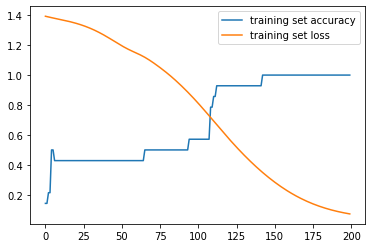

In [18]:
plt.plot(train.history['accuracy'],label='training set accuracy')
plt.plot(train.history['loss'],label='training set loss')
plt.legend()

In [19]:
!pip install gTTS

In [22]:
from gtts import gTTS
from IPython.display import Audio
import random
while True:
  texts_p= []
  prediction_input= input('You: ')
  prediction_input= [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input= ''.join(prediction_input)
  texts_p.append(prediction_input)
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input= pad_sequences([prediction_input],input_shape)
  output = model.predict(prediction_input)
  output = output.argmax()
  response_tag = le.inverse_transform([output])[0]
  print("Salesman :",random.choice(responses[response_tag]))
  if response_tag == 'goodbye':
    break

You: hey
Salesman : Hey how can i help you
You: Is this an electronics shop?
Salesman : Yes,our shop sells electronics
You: Where is your shop located?
Salesman : Vijayanagar
You: bye bye
Salesman : Thank you customer,hope you have a nice day
